In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from autogluon.timeseries import TimeSeriesDataFrame
import pandas as pd
import numpy as np
from chronos import BaseChronosPipeline
from models import predict_chronos
from chronos import BaseChronosPipeline

In [5]:
# read in data. Here only using data from 2021-2025 for first tests
df = pd.read_csv("data/Realisierter_Stromverbrauch_202103010000_202503270000_Stunde.csv", thousands=".", decimal=",", sep=";")

# bring data in right shape
for col in df.columns[2:]:
    df[col] = df[col].str.replace('.', '')
    df[col] = df[col].str.replace(',', '.').replace("-",np.nan).astype(float)
df = df[["Datum von", "Netzlast [MWh] Berechnete Auflösungen"]].copy()
df = df.rename(columns={"Datum von":"timestamp", "Netzlast [MWh] Berechnete Auflösungen": "target"})
df["item_id"] = 0 
df["timestamp"] = pd.to_datetime(df["timestamp"], dayfirst=True)
df = df.drop_duplicates(subset=["item_id","timestamp"], keep="first")

In [6]:
df.tail(20)

,timestamp,target,item_id
35668,2025-03-26 04:00:00,46351.50,0
35669,2025-03-26 05:00:00,49857.25,0
35670,2025-03-26 06:00:00,56725.50,0
35671,2025-03-26 07:00:00,60778.00,0
35672,2025-03-26 08:00:00,63646.00,0
35673,2025-03-26 09:00:00,64506.75,0
35674,2025-03-26 10:00:00,65507.25,0
35675,2025-03-26 11:00:00,66186.00,0
35676,2025-03-26 12:00:00,65441.00,0
35677,2025-03-26 13:00:00,64230.50,0


In [21]:
# create TimesSeriesDataFrame
data = TimeSeriesDataFrame(df)
# split data in train and test
data_train, data_test = data.split_by_time(pd.Timestamp("01-01-2023"))

# Chronos Bolt Zero Shot

In [22]:
# load model
pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-bolt-tiny", # could also use e.g. "amazon/chronos-bolt-small", "amazon/chronos-bolt-base", "amazon/chronos-bolt-large"
    device_map="mps", # mps for using mac gpu
)

In [23]:
predictions_raw = predict_chronos(pipeline=pipeline, 
                                  data=data_test, 
                                  lead_times=np.arange(1,65),
                                  freq=pd.Timedelta("1h"))

100%|██████████| 306/306 [00:12<00:00, 24.18it/s]


In [25]:
predictions_raw.get_crps(mean=True)

1388.9687159292198

In [24]:
# calculate crps for all lead times (1 to 64)
predictions_raw.get_crps()

{1: 614.4922082008098,
 2: 747.6605021673224,
 3: 837.1297197573348,
 4: 913.5434796784774,
 5: 970.9978606360938,
 6: 1020.2504691341857,
 7: 1061.9064708492872,
 8: 1088.654438207666,
 9: 1118.0452493108444,
 10: 1149.7327961767571,
 11: 1173.0910850823134,
 12: 1196.759311830442,
 13: 1214.3868745828363,
 14: 1235.7120379706735,
 15: 1249.3958284853063,
 16: 1256.0256565952338,
 17: 1267.980736655843,
 18: 1280.3071609953408,
 19: 1285.3103992154383,
 20: 1293.3891583714596,
 21: 1293.561713728224,
 22: 1299.0475025907137,
 23: 1309.4899926945686,
 24: 1321.525632761391,
 25: 1354.2864667381255,
 26: 1382.3296481179798,
 27: 1407.232484317177,
 28: 1432.1941530002875,
 29: 1453.2372872633189,
 30: 1471.4694895959478,
 31: 1479.1360729894266,
 32: 1482.3636916406886,
 33: 1486.815754035525,
 34: 1490.7739028020349,
 35: 1499.8664466502598,
 36: 1502.7350481840367,
 37: 1502.666816012568,
 38: 1510.8839419275942,
 39: 1516.4980372616867,
 40: 1522.6769087009804,
 41: 1525.330555365340

In [ ]:
# alternatively only get results for certain lead times (in h)
predictions_raw.get_crps(lead_times=[1, 12, 24, 32, 48, 64])

{1: 614.4922082008098,
 12: 1196.759311830442,
 24: 1321.525632761391,
 32: 1482.3636916406886,
 48: 1542.8868614432174,
 64: 1703.8207140067298}

In [18]:
# get empirical coverage rates
predictions_raw.get_empirical_coverage_rates([1, 12, 24, 32, 48, 64])

,1,12,24,32,48,64
0.1,0.025789,0.080125,0.077673,0.081248,0.089981,0.096109
0.2,0.097487,0.174599,0.177255,0.163262,0.179144,0.174037
0.3,0.201818,0.263967,0.278317,0.248749,0.272853,0.257379
0.4,0.323818,0.358952,0.376826,0.337861,0.370187,0.347360
0.5,0.463283,0.457614,0.466193,0.427740,0.466653,0.443009
0.6,0.608773,0.559544,0.566796,0.520887,0.563017,0.542794
0.7,0.752426,0.671586,0.667756,0.623634,0.662905,0.650087
0.8,0.878919,0.789194,0.780360,0.737872,0.768818,0.758554
0.9,0.971862,0.910888,0.907875,0.876162,0.895567,0.883158


<Figure size 800x800 with 0 Axes>

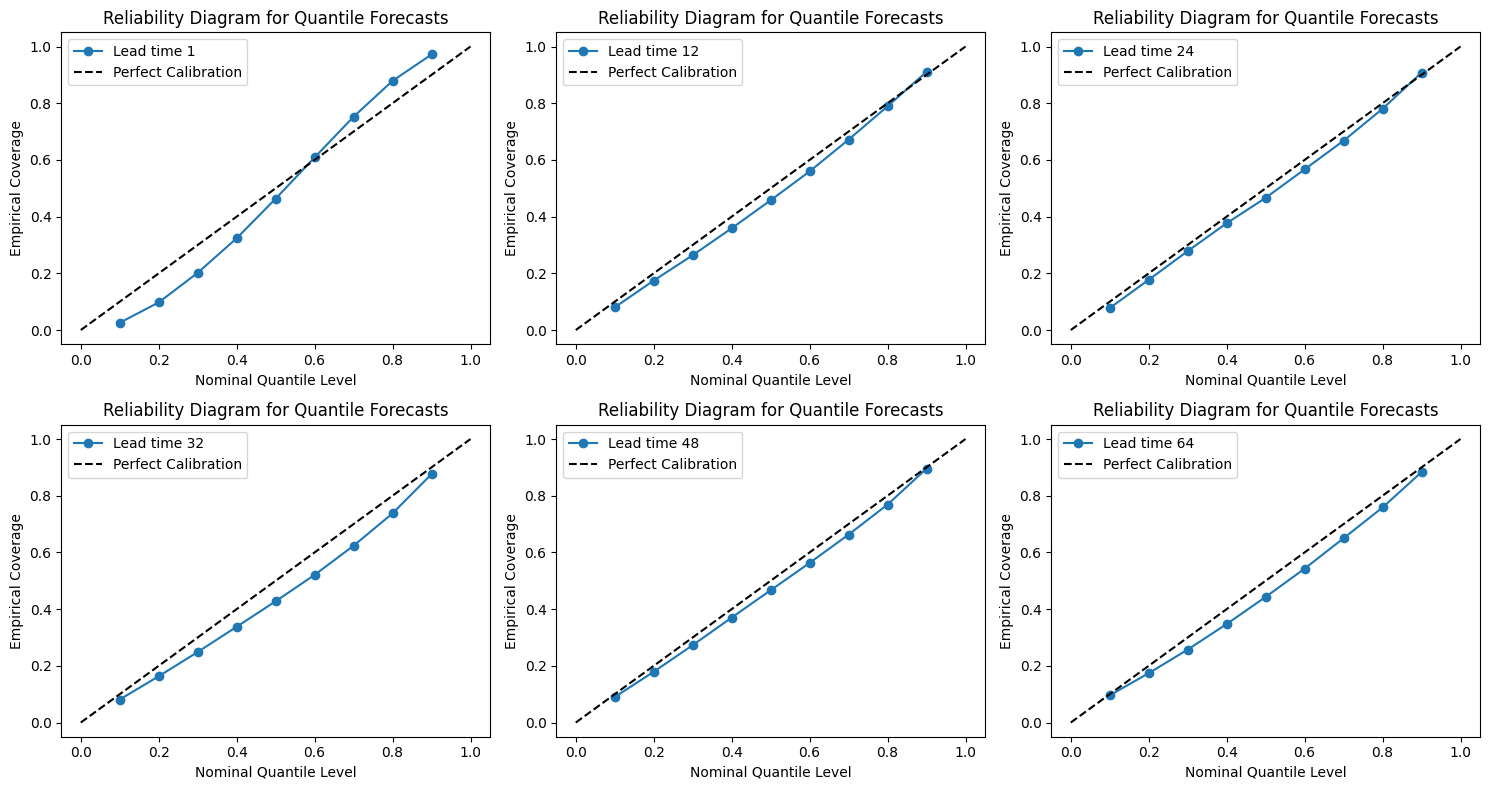

In [19]:
# plot reliability diagrams
predictions_raw.get_reliability_diagram([1, 12, 24, 32, 48, 64])

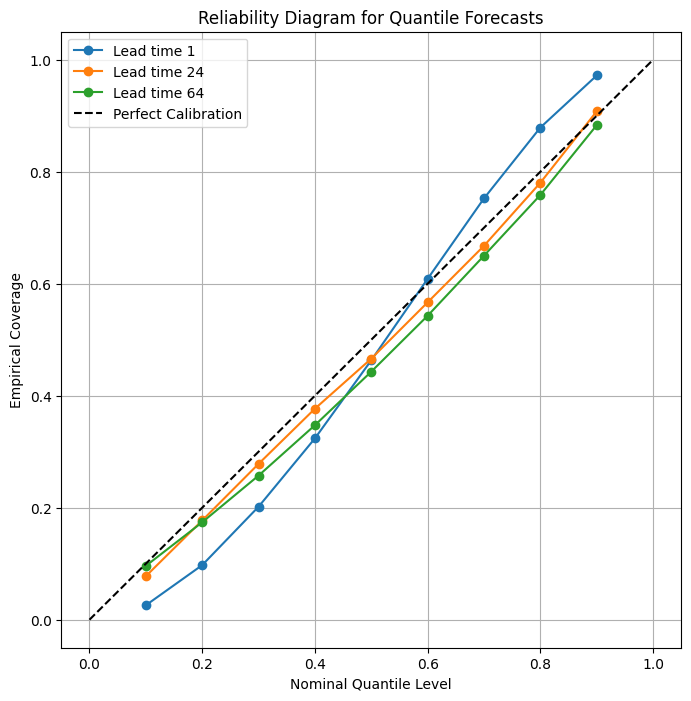

In [20]:
# use overlay
predictions_raw.get_reliability_diagram([1, 24, 64], overlay=True)

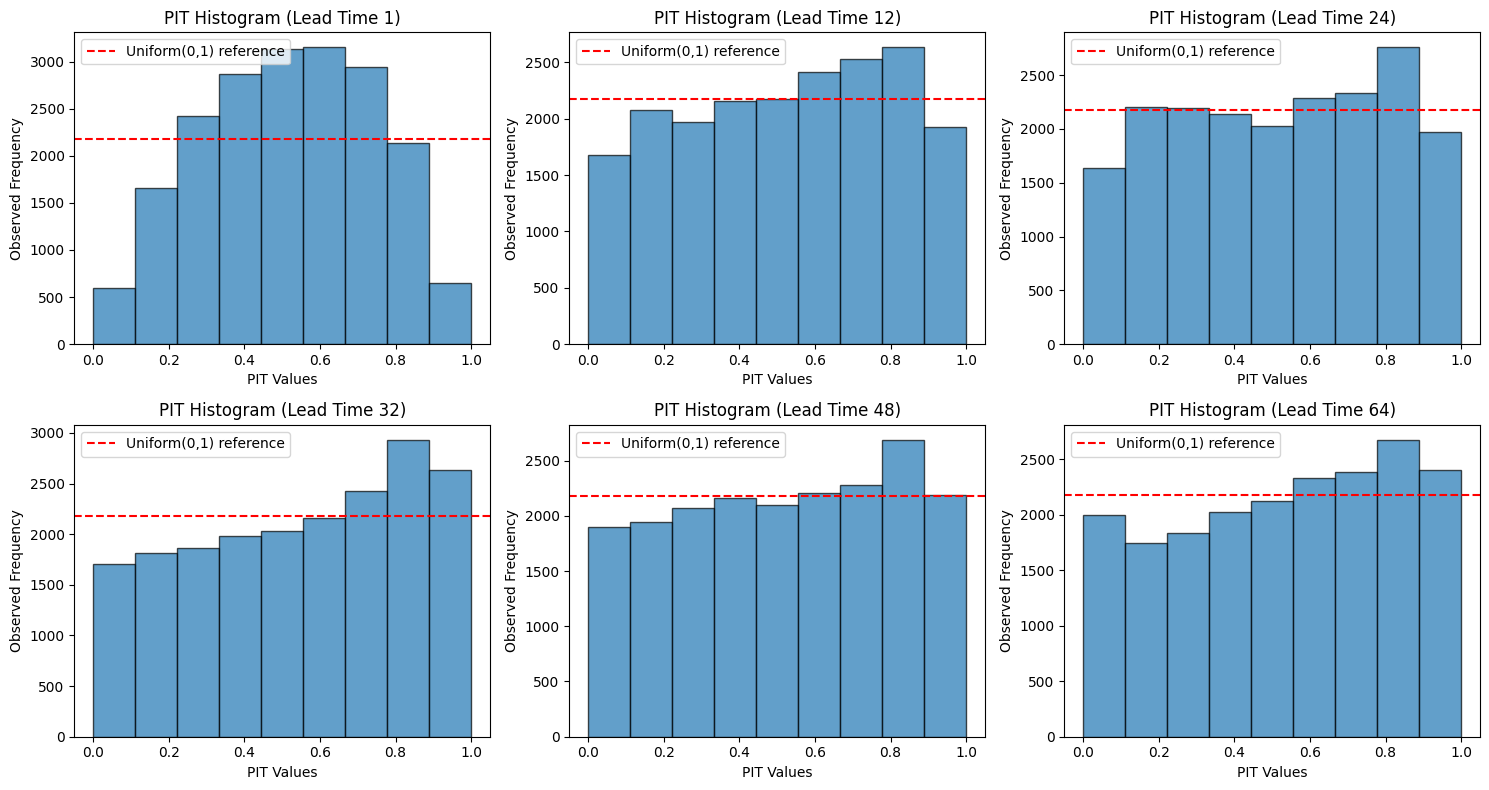

In [21]:
# plot PIT histograms
predictions_raw.get_pit_histogram([1, 12, 24, 32, 48, 64])

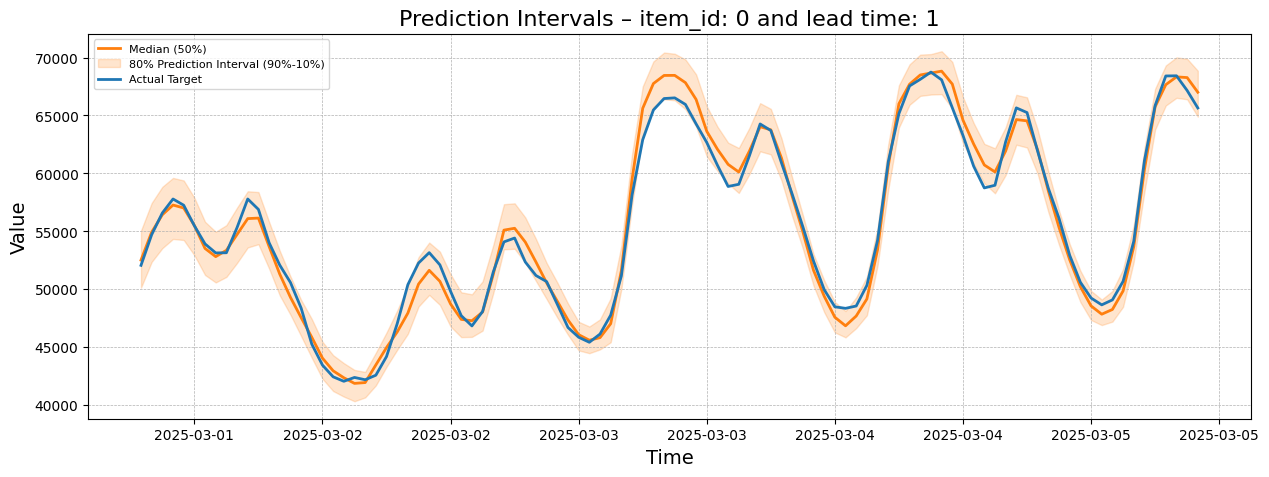

In [26]:
# plot random subset of the predictions
predictions_raw.results[1].get_random_plot()

# Postprocessing

## Parametric Approximation of Log-Normal Distribution
- (V1) Fitte Normalverteilung für log Y, mit folgender Parametrisierung: mean = a + b*M, wobei M = Median-Vorhersage des Modells für log Y. Standardabweichung = c + d*IQR, wobei IQR = Interquartilsabstand (z.B. 90%-10%) des Modells für log Y. Falls sich die Modellvorhersagen anfangs auf Y (statt log Y) beziehen kannst Du die einfach logarithmieren, das ist einer der Vorteile von Quantilen.

In [28]:
from statsmodels.graphics.gofplots import qqplot
import matplotlib.pyplot as plt
from postprocessing import postprocess_mle

In [10]:
# get zero shot predictions on training dataset
predictions_train = predict_chronos(pipeline=pipeline, 
                                    data=data_train, 
                                    lead_times=np.arange(1,65),
                                    freq=pd.Timedelta("1h"))

100%|██████████| 252/252 [00:10<00:00, 23.87it/s]


check if data is normally distributed

In [11]:
# get target variable
log_target = np.log(predictions_train.results[1].data["target"])

<Axes: >

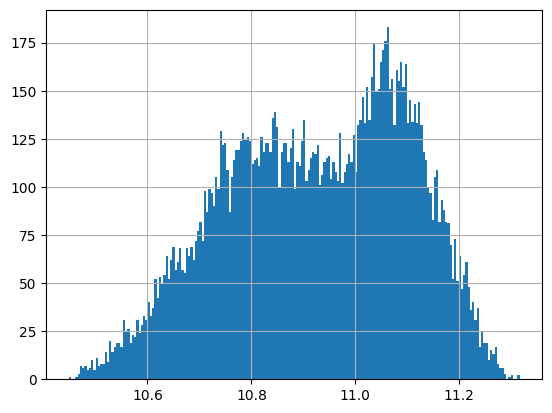

In [12]:
# plot histogram of target variable
log_target.hist(bins=200)

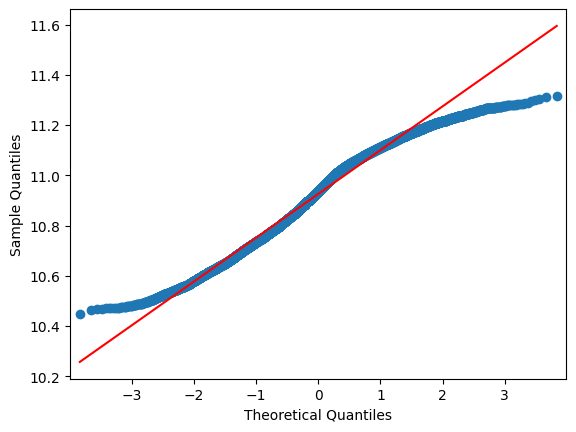

In [13]:
# q-q plot
qqplot(log_target, line='s')
plt.show()

In [31]:
predictions_nrml = postprocess_mle(predictions_train=predictions_train, predictions_test=predictions_raw)

100%|██████████| 64/64 [00:06<00:00, 10.39it/s]


In [32]:
predictions_nrml.get_crps(mean=True)

1405.6019863971871

In [35]:
predictions_nrml.get_crps()

{1: 561.4331055212426,
 2: 720.5758766671391,
 3: 816.2520062833116,
 4: 897.8754099768821,
 5: 958.5094016644292,
 6: 1011.2917059814108,
 7: 1057.57055334496,
 8: 1085.395230934027,
 9: 1111.6457183330692,
 10: 1147.6395717682597,
 11: 1172.5187167183237,
 12: 1197.029240747005,
 13: 1213.234477128754,
 14: 1234.3857922077261,
 15: 1248.825311596026,
 16: 1252.7375048816368,
 17: 1266.023476234314,
 18: 1282.1593257676795,
 19: 1285.9901569735816,
 20: 1292.5549556244005,
 21: 1297.5674759235744,
 22: 1304.4345749056583,
 23: 1315.2558432372075,
 24: 1325.2066284333646,
 25: 1351.767140066309,
 26: 1375.6629608001374,
 27: 1394.935264097967,
 28: 1413.9135722116348,
 29: 1433.98423918509,
 30: 1451.1232054024574,
 31: 1458.6477589288472,
 32: 1462.747521060346,
 33: 1468.5720841716113,
 34: 1481.4682435793572,
 35: 1493.3204852198674,
 36: 1499.354712618917,
 37: 1500.8432849962137,
 38: 1509.3077136544916,
 39: 1515.7556116376272,
 40: 1519.4896803861138,
 41: 1523.0667906400888,
 4

In [27]:
predictions_nrml.get_crps(lead_times=[1, 12, 24, 32, 48, 64])

{1: 561.4331055212426,
 12: 1197.029240747005,
 24: 1325.2066284333646,
 32: 1462.747521060346,
 48: 1552.2607342624285,
 64: 1692.0085536580327}

<Figure size 800x800 with 0 Axes>

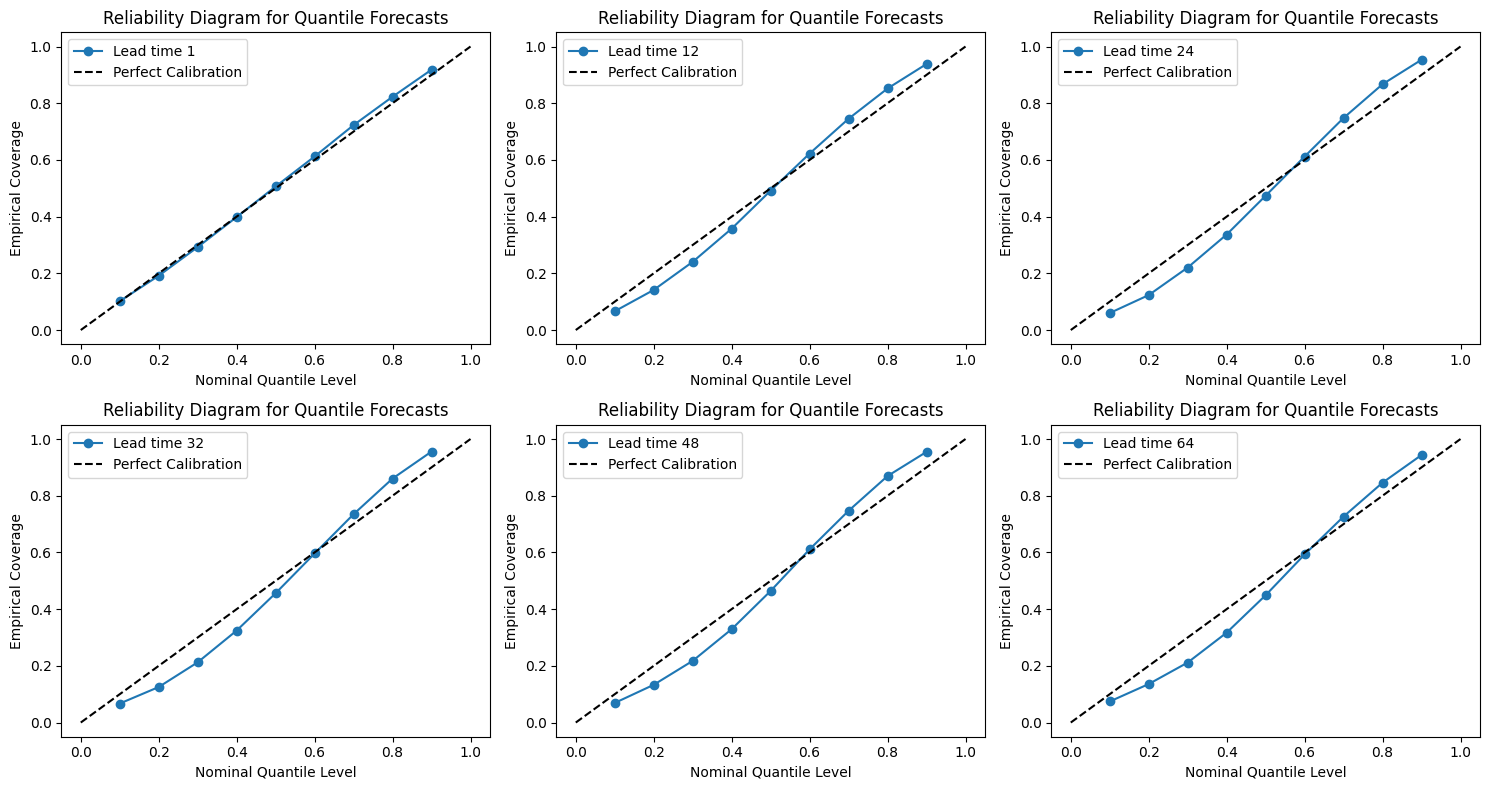

In [28]:
predictions_nrml.get_reliability_diagram(lead_times=[1, 12, 24, 32, 48, 64])

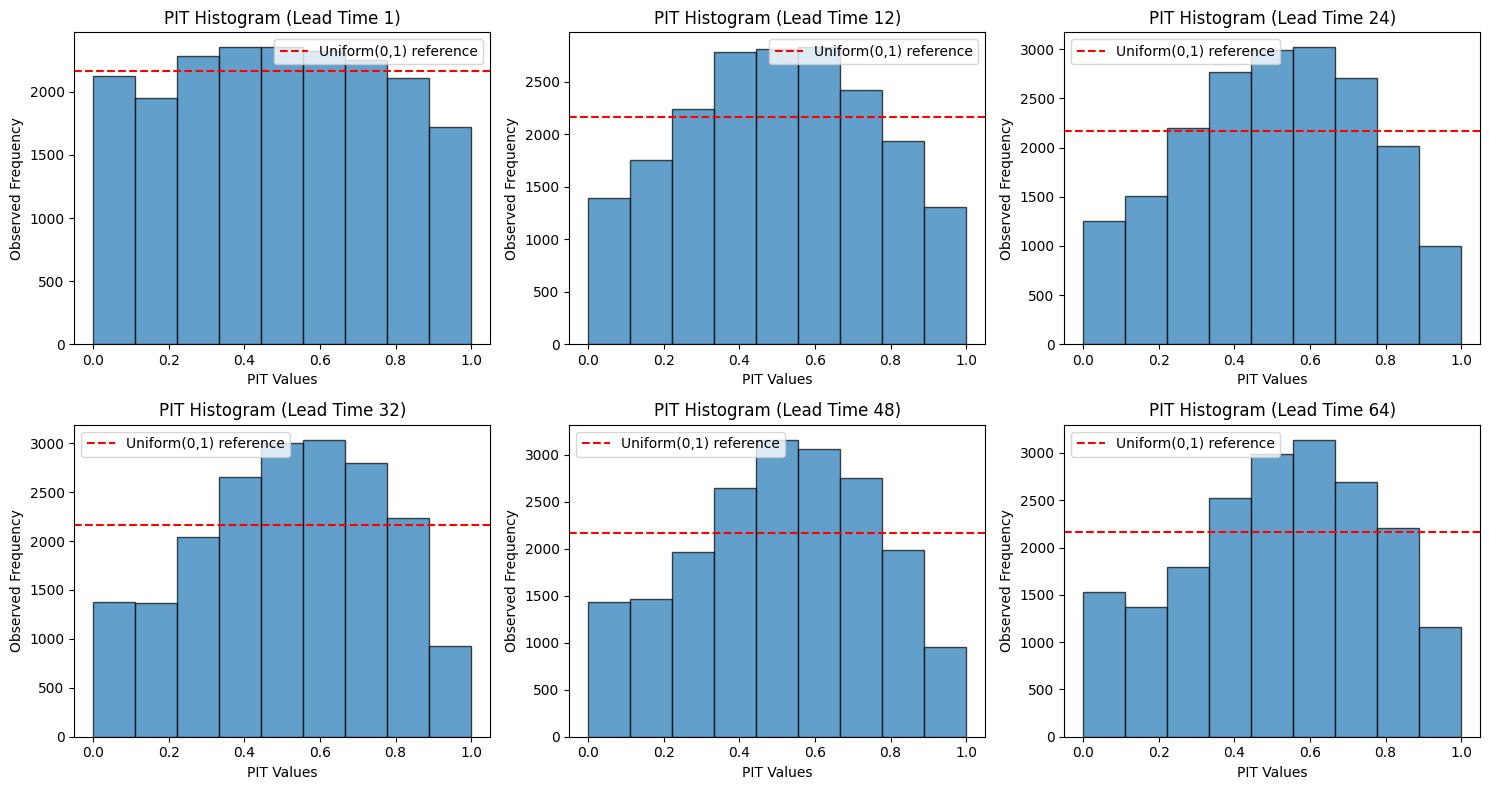

In [29]:
predictions_nrml.get_pit_histogram(lead_times=[1, 12, 24, 32, 48, 64])

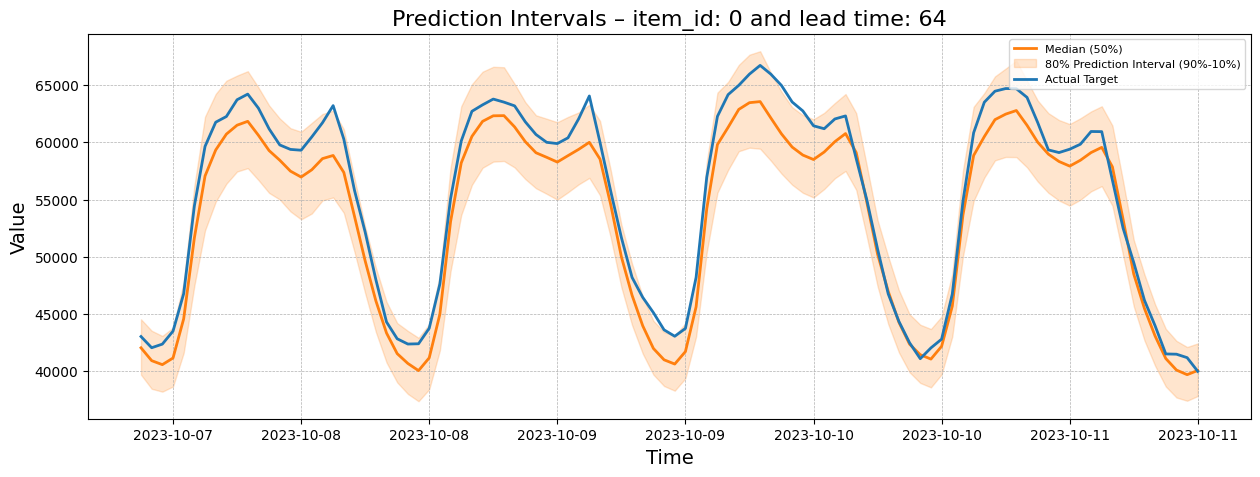

In [48]:
# plot a random part of the predictions
predictions_nrml.results[64].get_random_plot()

## Quantile Regression

-  (V2) Fitte separate Quantilsregression für jedes Quantil (z.B. 10%, 20%, ..., 90%). D.h. für jedes Level eine Quantilsregression mit Konstante und einem Regressor (= Quantils-Vorhersage des Modells). Der Spezialfall mit Konstante = 0 und Slope = 1 würde dann heißen, dass die Vorhersagen bereits perfekt kalibriert sind.



In [33]:
from postprocessing import postprocess_quantreg

In [40]:
# get zero shot predictions on training dataset
predictions_train = predict_chronos(pipeline=pipeline, 
                                    data=data_train, 
                                    lead_times=np.arange(1,65),
                                    freq=pd.Timedelta("1h"))

100%|██████████| 252/252 [00:10<00:00, 24.49it/s]


In [34]:
predictions_qr = postprocess_quantreg(predictions_train=predictions_train, predictions_test=predictions_raw)

100%|██████████| 64/64 [00:39<00:00,  1.60it/s]


In [35]:
predictions_qr.get_crps(mean=True)

1375.6408461047113

In [54]:
predictions_qr.get_crps(lead_times=[1, 12, 24, 32, 48, 64])

{1: 564.209185307121,
 12: 1187.926850830314,
 24: 1309.1313161751063,
 32: 1455.9091182084412,
 48: 1529.5548502641122,
 64: 1694.7950825928756}

In [43]:
predictions_qr.get_quantile_scores([1, 12, 24, 32, 48, 64])

,1,12,24,32,48,64
0.1,173.586143,401.228162,483.261271,547.653254,582.159867,635.020072
0.2,265.804678,571.037708,657.054232,743.874623,787.462882,868.059492
0.3,322.145345,676.751393,761.215627,854.348976,898.761390,993.359317
0.4,351.290526,732.703991,810.732822,904.227590,948.250161,1045.811054
0.5,358.823831,747.085338,814.752552,904.353063,946.567166,1042.459822
0.6,345.016938,717.899743,774.042084,854.523141,895.931953,989.007342
0.7,310.353964,644.620406,687.863822,755.429633,793.110108,884.422722
0.8,251.052477,520.603439,551.130222,602.909299,631.418651,712.790836
0.9,160.867432,333.740649,351.038288,384.271453,399.334649,455.647214


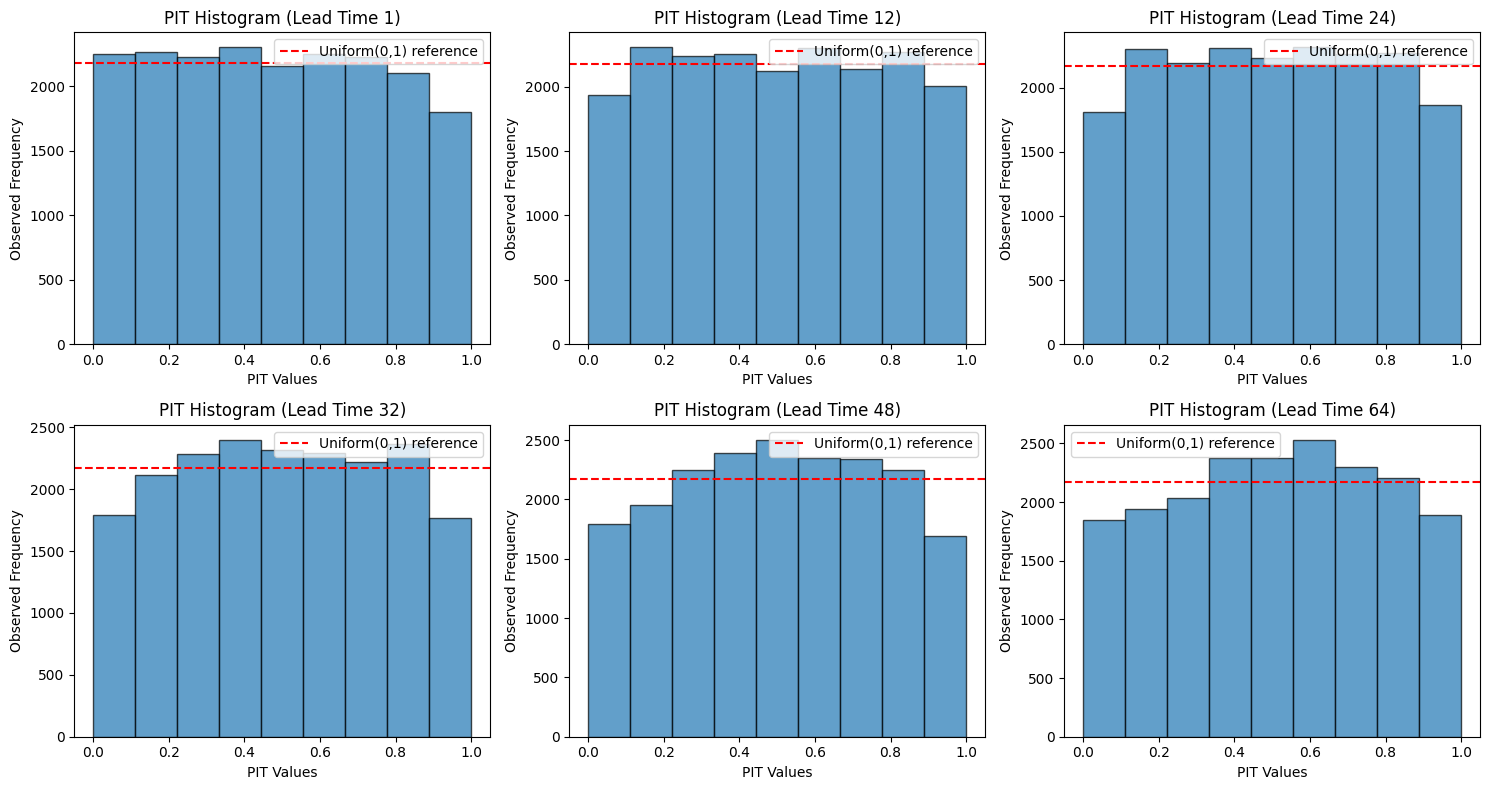

In [44]:
predictions_qr.get_pit_histogram([1, 12, 24, 32, 48, 64])

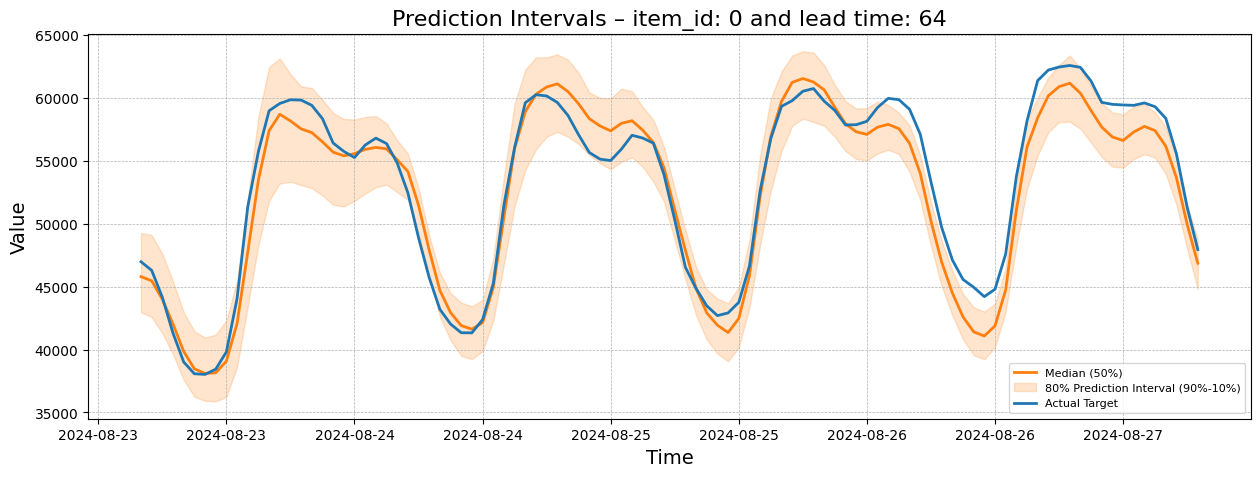

In [46]:
predictions_qr.results[64].get_random_plot()

# Benchmark

## Quantile Regression 

- simple quantile regresssion with seasonal variables (only calculated based on time information)

In [36]:
from benchmark import quantile_regression

In [37]:
quantiles = np.arange(0.1, 1, 0.1)
lead_times = np.arange(1, 65)
freq = pd.Timedelta("1h")
prediction_benchmark_qr = quantile_regression(data_train, data_test, quantiles, lead_times, freq)

100%|██████████| 64/64 [20:00<00:00, 18.75s/it]  


In [38]:
prediction_benchmark_qr.get_crps(mean=True)

3745.9573217938823

In [39]:
prediction_benchmark_qr.get_crps(lead_times=[1, 12, 24, 32, 48, 64])

{1: 3986.654856236878,
 12: 3923.563694957106,
 24: 3829.7685276607854,
 32: 3652.675143458914,
 48: 3774.5953553311338,
 64: 3692.6389431558114}

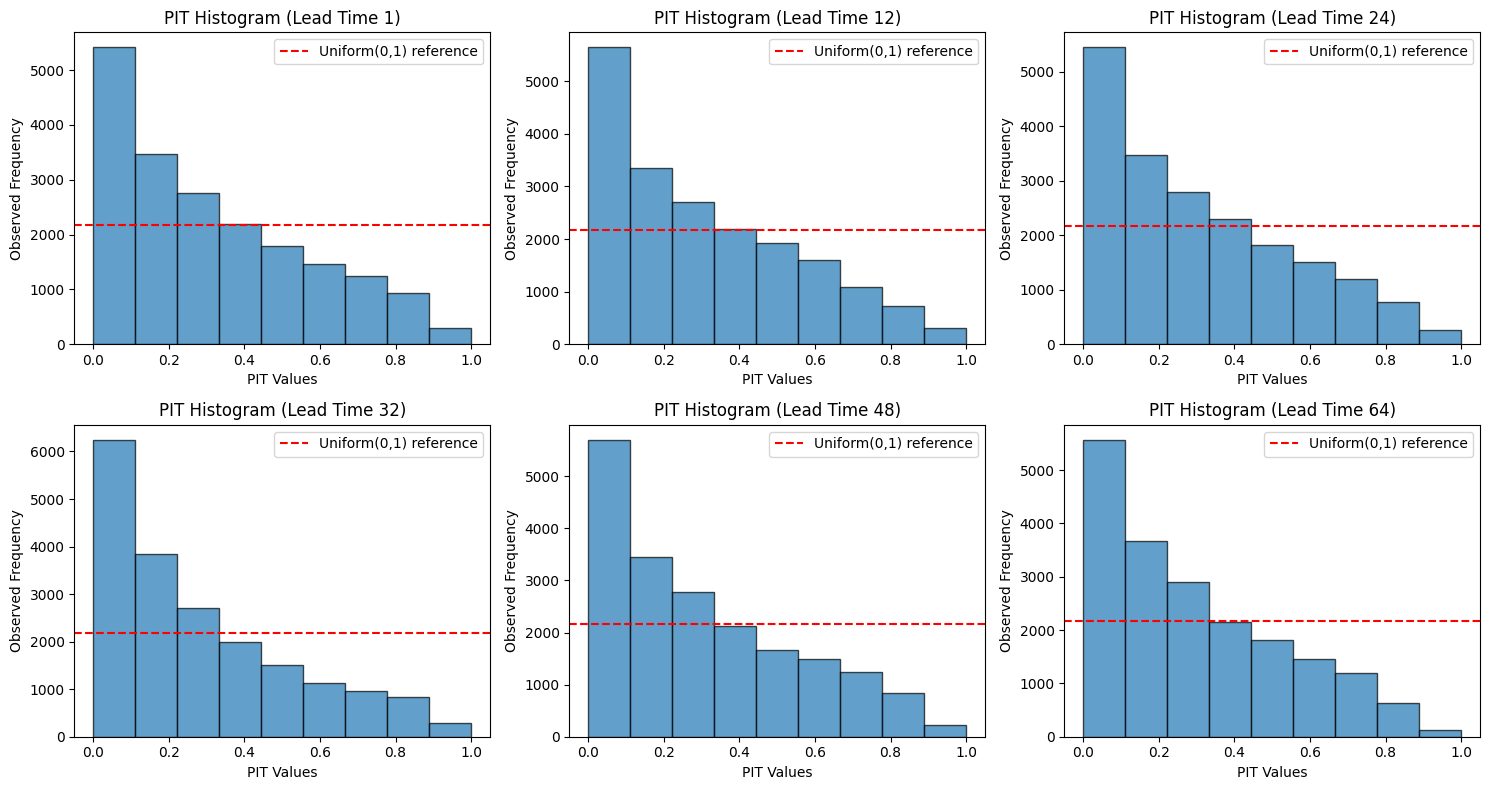

In [51]:
prediction_benchmark_qr.get_pit_histogram(lead_times=[1, 12, 24, 32, 48, 64])

<Figure size 800x800 with 0 Axes>

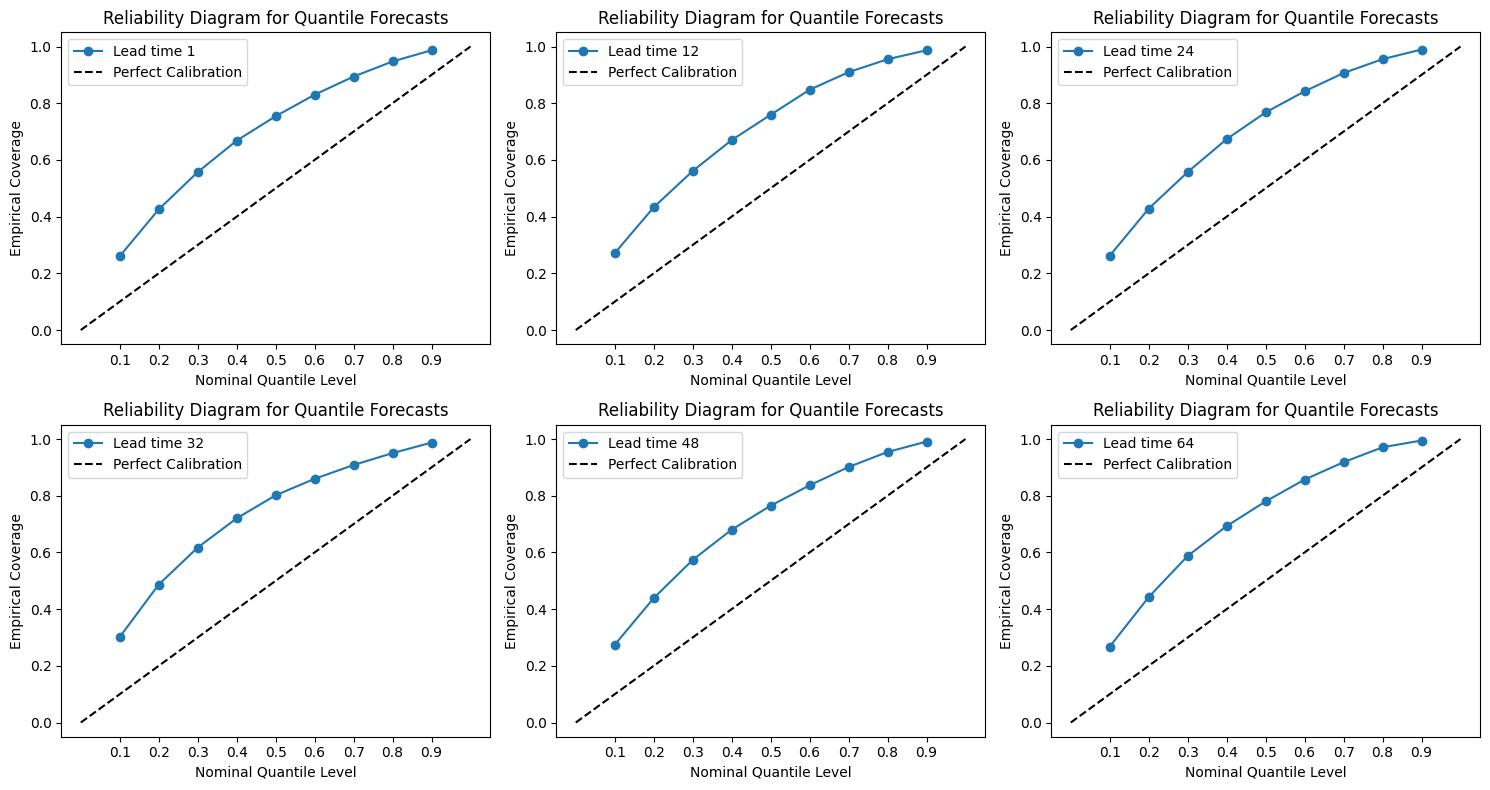

In [40]:
prediction_benchmark_qr.get_reliability_diagram(lead_times=[1, 12, 24, 32, 48, 64])

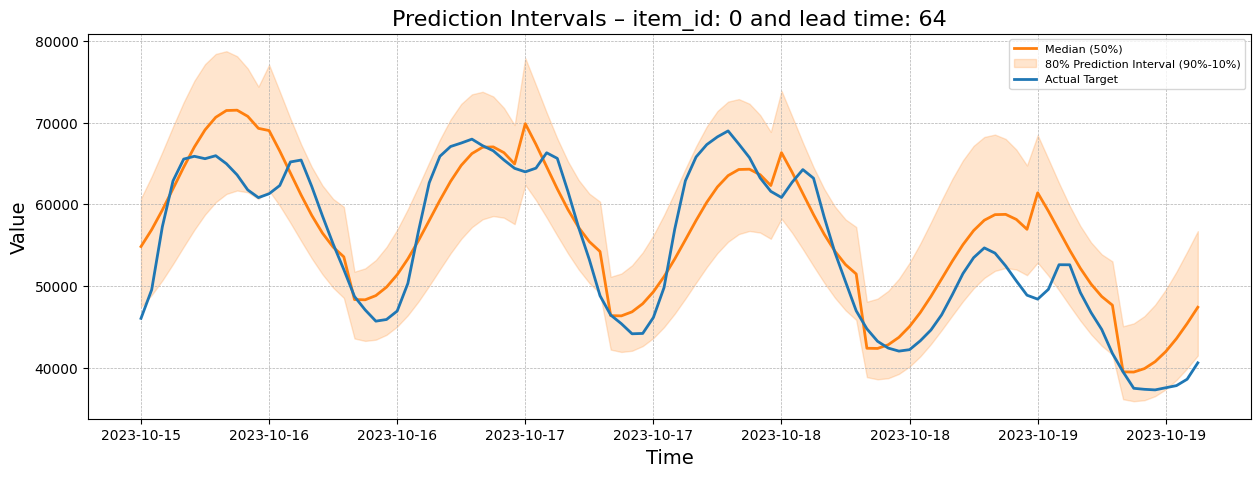

In [52]:
prediction_benchmark_qr.results[64].get_random_plot()

## Nearest Neigbour Approach
- einfacher benchmark
- Berechne empirische Quantile basierend auf den Werten für gleicher Wochentag, gleiche Stunde.

In [ ]:
from benchmark import forecast_from_weekday_hour_patterns, initialize_weekday_hour_dict

In [ ]:
# create dictionary to store the past values
weekday_hour_target = initialize_weekday_hour_dict()
percentiles = np.arange(10, 100, 10)
lead_times = np.arange(1,65)
freq = pd.Timedelta("1h")

predictions_train, weekday_hour_target = forecast_from_weekday_hour_patterns(data_train, weekday_hour_target, lead_times, percentiles, freq, last_n_samples=20)
# make predictions for test data
predictions_benchmark_nn, weekday_hour_target = forecast_from_weekday_hour_patterns(data_test, weekday_hour_target, lead_times, percentiles, freq, last_n_samples=20)

In [ ]:
predictions_benchmark_nn.get_crps(mean=True)

3093.632639932858

In [ ]:
predictions_benchmark_nn.get_crps(lead_times=[1, 12, 24, 32, 48, 64])

{1: 3093.3053142527874,
 12: 3092.927692006203,
 24: 3093.4441035062887,
 32: 3092.6198315507563,
 48: 3094.2500680893445,
 64: 3094.9962587352848}

<Figure size 800x800 with 0 Axes>

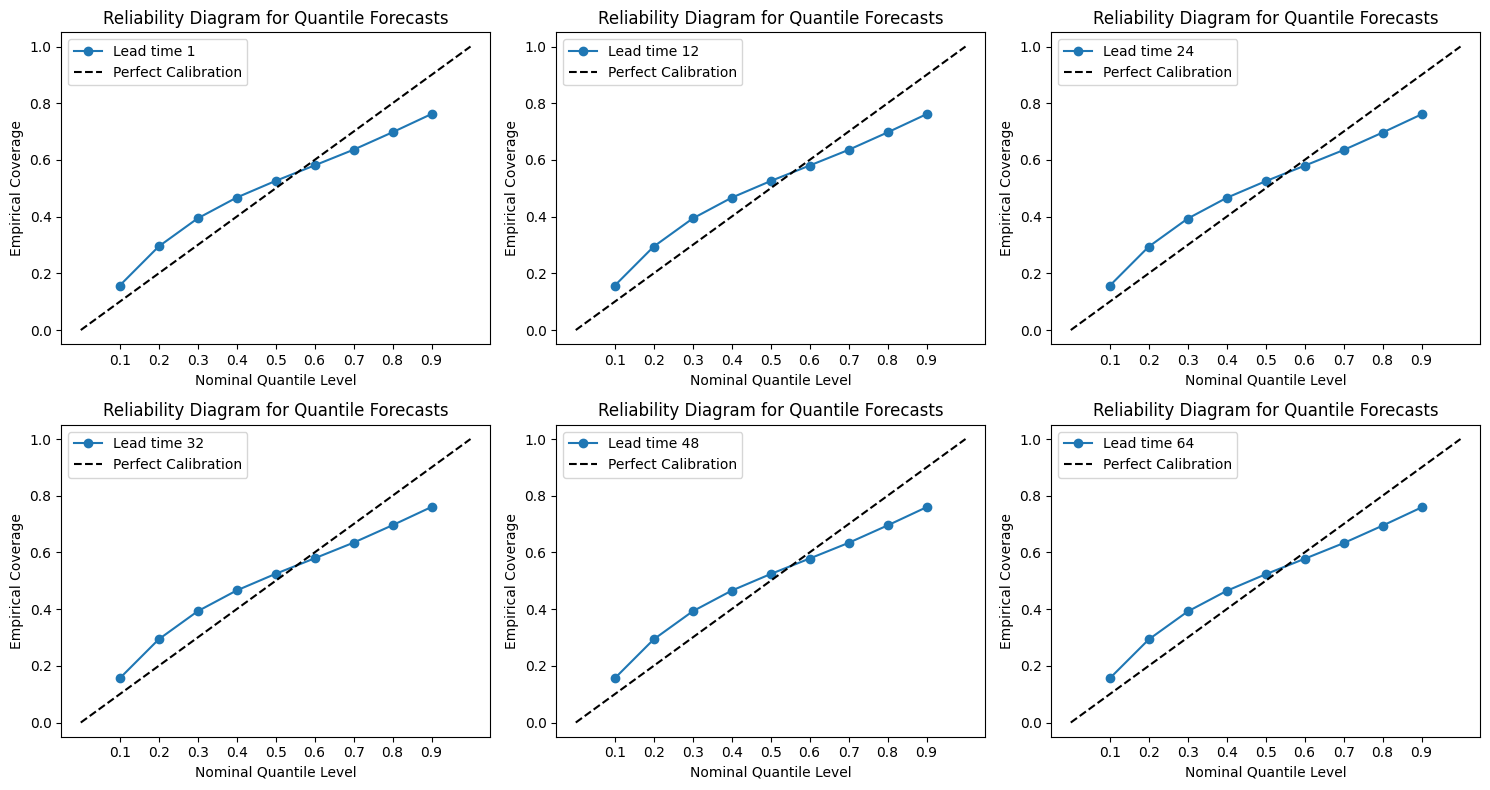

In [ ]:
predictions_benchmark_nn.get_reliability_diagram(lead_times=[1, 12, 24, 32, 48, 64])

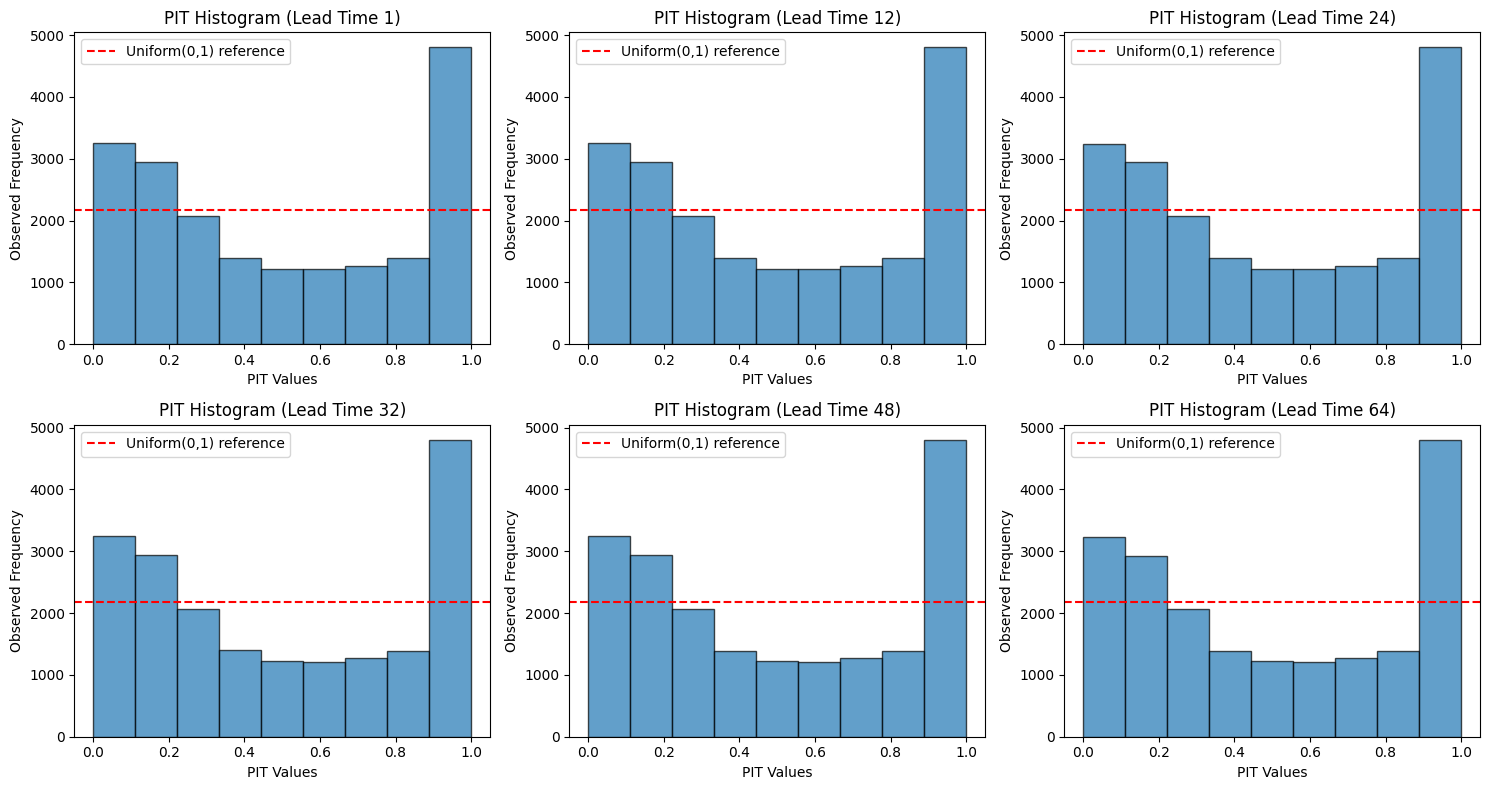

In [ ]:
predictions_benchmark_nn.get_pit_histogram(lead_times=[1, 12, 24, 32, 48, 64])

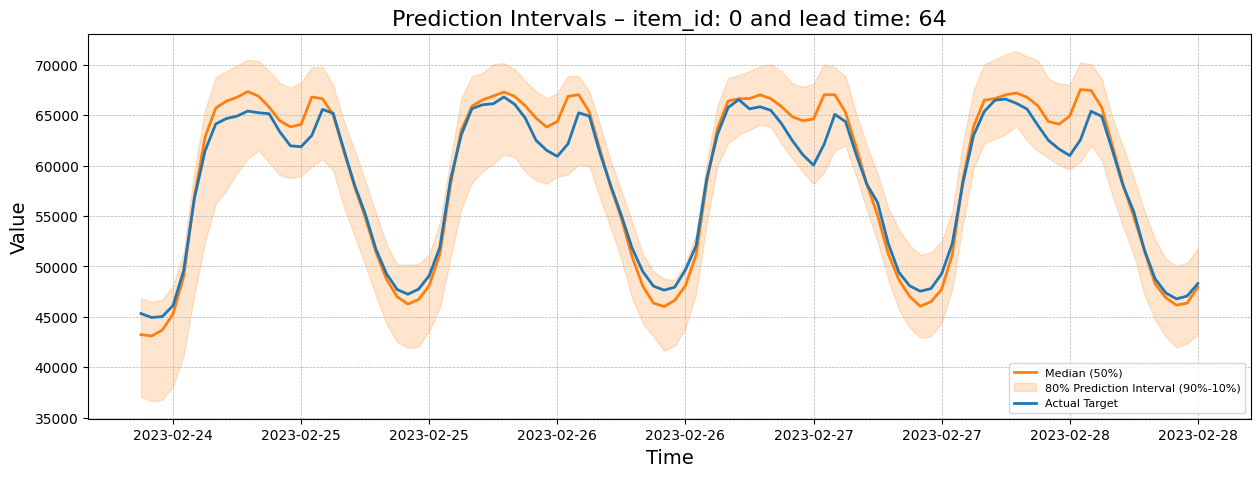

In [ ]:
predictions_benchmark_nn.results[64].get_random_plot()